# 1 Introducción

En este notebook se va a realizar el análisis de sentimiento de las reviews de Amazon correspondiente a cinco categorías diferentes.

En un primer momento se realiza una análisis considerando únicamente sentimiento positivo o negativo. Este estudio inicial se realizará con una regresión logarítmica. 

Seguidamente, se realizará un segundo análisis, pero teniendo en cuenta sentimientos positivos, negativos y neutros. En este caso se utilizarán otras técnicas, como Multinomial Naive Bayes, SVM, Decision Tree y Random Forest. Del sistema que mejores resultados proporcione, SVM, se realizará un estudio más detallado.

Finalmente, se realiza un análisis de sentimiento utilizando VADER.

## 1.1 Funciones y librerías generales

In [1]:
# Librerías más usadas a lo largo del notebook. 
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

from nltk.stem import WordNetLemmatizer

import gensim

from wordcloud import WordCloud

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
import warnings
warnings.filterwarnings('ignore')

# Por defecto mostramos todas las columnas y filas de los datasets
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Librerías para análisis de sentimiento
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve

# 2 Carga de datos para modelado de topics y análisis de sentimiento

Los datos que se van a procesar para el modelado de topics y análisis de sentimiento se obtienen de reviews de Amazon localizadas en http://jmcauley.ucsd.edu/data/amazon/. Para agilizar la ejecución del notebook se han descargado previamente cinco datasets de tipo 5-core y se han guardado en la subcarpeta _data_. Las cinco categorías descargadas son:

- Automotive
- Clothing Shoes and Jewelry
- Home and Kitchen
- Office Products
- Sports and Outdoors

## 2.1 Carga de datasets por categoría/tema


df_automotive = pd.read_json('data/reviews_Automotive_5.json.gz', lines=True)
df_automotive.head().T

In [3]:
df_automotive.shape

(20473, 9)

In [4]:
df_automotive.dtypes

reviewerID        object
asin              object
reviewerName      object
helpful           object
reviewText        object
overall            int64
summary           object
unixReviewTime     int64
reviewTime        object
dtype: object

In [5]:
df_automotive.isna().sum()

reviewerID          0
asin                0
reviewerName      213
helpful             0
reviewText          0
overall             0
summary             0
unixReviewTime      0
reviewTime          0
dtype: int64

In [6]:
df_clothing = pd.read_json('data/reviews_Clothing_Shoes_and_Jewelry_5.json.gz', lines=True)
df_clothing.head().T

0  \
reviewerID                                         A1KLRMWW2FWPL4   
asin                                                   0000031887   
reviewerName                          Amazon Customer "cameramom"   
helpful                                                    [0, 0]   
reviewText      This is a great tutu and at a really great pri...   
overall                                                         5   
summary                             Great tutu-  not cheaply made   
unixReviewTime                                         1297468800   
reviewTime                                            02 12, 2011   

                                                                1  \
reviewerID                                         A2G5TCU2WDFZ65   
asin                                                   0000031887   
reviewerName                                      Amazon Customer   
helpful                                                    [0, 0]   
reviewText      I bought this for my 4 yr old daughter for dan...   
overall                                                         5   
summary                                               Very Cute!!   
unixReviewTime                                         1358553600   
reviewTime                                            01 19, 2013   

                                                                2  \
reviewerID                                         A1RLQXYNCMWRWN   
asin                                                   0000031887   
reviewerName                                               Carola   
helpful                                                    [0, 0]   
reviewText      What can I say... my daughters have it in oran...   
overall                                                         5   
summary                                  I have buy more than one   
unixReviewTime                                         1357257600   
reviewTime                                             01 4, 2013   

                                                                3  \
reviewerID                                          A8U3FAMSJVHS5   
asin                                                   0000031887   
reviewerName                                              Caromcg   
helpful                                                    [0, 0]   
reviewText      We bought several tutus at once, and they are ...   
overall                                                         5   
summary                                          Adorable, Sturdy   
unixReviewTime                                         1398556800   
reviewTime                                            04 27, 2014   

                                                                4  
reviewerID                                         A3GEOILWLK86XM  
asin                                                   0000031887  
reviewerName                                                   CJ  
helpful                                                    [0, 0]  
reviewText      Thank you Halo Heaven great product for Little...  
overall                                                         5  
summary                                   Grammy's Angels Love it  
unixReviewTime                                         1394841600  
reviewTime                                            03 15, 2014

In [7]:
df_clothing.shape

(278677, 9)

In [8]:
df_clothing.isna().sum()

reviewerID          0
asin                0
reviewerName      452
helpful             0
reviewText          0
overall             0
summary             0
unixReviewTime      0
reviewTime          0
dtype: int64

In [9]:
df_office = pd.read_json('data/reviews_Office_Products_5.json.gz', lines=True)
df_office.head().T

0  \
reviewerID                                         A32T2H8150OJLU   
asin                                                   B00000JBLH   
reviewerName                                                  ARH   
helpful                                                    [3, 4]   
reviewText      I bought my first HP12C in about 1984 or so, a...   
overall                                                         5   
summary                   A solid performer, and long time friend   
unixReviewTime                                         1094169600   
reviewTime                                             09 3, 2004   

                                                                1  \
reviewerID                                         A3MAFS04ZABRGO   
asin                                                   B00000JBLH   
reviewerName                                     Let it Be "Alan"   
helpful                                                    [7, 9]   
reviewText      WHY THIS BELATED REVIEW? I feel very obliged t...   
overall                                                         5   
summary         Price of GOLD is up, so don't bury the golden ...   
unixReviewTime                                         1197676800   
reviewTime                                            12 15, 2007   

                                                                2  \
reviewerID                                         A1F1A0QQP2XVH5   
asin                                                   B00000JBLH   
reviewerName                                               Mark B   
helpful                                                    [3, 3]   
reviewText      I have an HP 48GX that has been kicking for mo...   
overall                                                         2   
summary          Good functionality, but not durable like old HPs   
unixReviewTime                                         1293840000   
reviewTime                                             01 1, 2011   

                                                                3  \
reviewerID                                          A49R5DBXXQDE5   
asin                                                   B00000JBLH   
reviewerName                                         R. D Johnson   
helpful                                                    [7, 8]   
reviewText      I've started doing more finance stuff recently...   
overall                                                         5   
summary              One of the last of an almost extinct species   
unixReviewTime                                         1145404800   
reviewTime                                            04 19, 2006   

                                                                4  
reviewerID                                         A2XRMQA6PJ5ZJ8  
asin                                                   B00000JBLH  
reviewerName                                  Roger J. Buffington  
helpful                                                    [0, 0]  
reviewText      For simple calculations and discounted cash fl...  
overall                                                         5  
summary                                            Still the best  
unixReviewTime                                         1375574400  
reviewTime                                             08 4, 2013

In [10]:
df_office.shape

(53258, 9)

In [11]:
df_office.isna().sum()

reviewerID          0
asin                0
reviewerName      459
helpful             0
reviewText          0
overall             0
summary             0
unixReviewTime      0
reviewTime          0
dtype: int64

In [12]:
df_sports = pd.read_json('data/reviews_Sports_and_Outdoors_5.json.gz', lines=True)
df_sports.head().T

0  \
reviewerID                                           AIXZKN4ACSKI   
asin                                                   1881509818   
reviewerName                                         David Briner   
helpful                                                    [0, 0]   
reviewText      This came in on time and I am veru happy with ...   
overall                                                         5   
summary                                            Woks very good   
unixReviewTime                                         1390694400   
reviewTime                                            01 26, 2014   

                                                                1  \
reviewerID                                         A1L5P841VIO02V   
asin                                                   1881509818   
reviewerName                                      Jason A. Kramer   
helpful                                                    [1, 1]   
reviewText      I had a factory Glock tool that I was using fo...   
overall                                                         5   
summary                         Works as well as the factory tool   
unixReviewTime                                         1328140800   
reviewTime                                             02 2, 2012   

                                                                2  \
reviewerID                                          AB2W04NI4OEAD   
asin                                                   1881509818   
reviewerName                                           J. Fernald   
helpful                                                    [2, 2]   
reviewText      If you don't have a 3/32 punch or would like t...   
overall                                                         4   
summary                                 It's a punch, that's all.   
unixReviewTime                                         1330387200   
reviewTime                                            02 28, 2012   

                                                                3  \
reviewerID                                         A148SVSWKTJKU6   
asin                                                   1881509818   
reviewerName                       Jusitn A. Watts "Maverick9614"   
helpful                                                    [0, 0]   
reviewText      This works no better than any 3/32 punch you w...   
overall                                                         4   
summary                           It's a punch with a Glock logo.   
unixReviewTime                                         1328400000   
reviewTime                                             02 5, 2012   

                                                                4  
reviewerID                                          AAAWJ6LW9WMOO  
asin                                                   1881509818  
reviewerName                                         Material Man  
helpful                                                    [0, 0]  
reviewText      I purchased this thinking maybe I need a speci...  
overall                                                         4  
summary                   Ok,tool does what a regular punch does.  
unixReviewTime                                         1366675200  
reviewTime                                            04 23, 2013

In [13]:
df_sports.shape

(296337, 9)

In [14]:
df_sports.isna().sum()

reviewerID           0
asin                 0
reviewerName      1402
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

In [15]:
df_home = pd.read_json('data/reviews_Home_and_Kitchen_5.json.gz', lines=True)
df_home.head().T

0  \
reviewerID                                          APYOBQE6M18AA   
asin                                                   0615391206   
reviewerName                                      Martin Schwartz   
helpful                                                    [0, 0]   
reviewText      My daughter wanted this book and the price on ...   
overall                                                         5   
summary                                                Best Price   
unixReviewTime                                         1382140800   
reviewTime                                            10 19, 2013   

                                                                1  \
reviewerID                                         A1JVQTAGHYOL7F   
asin                                                   0615391206   
reviewerName                                        Michelle Dinh   
helpful                                                    [0, 0]   
reviewText      I bought this zoku quick pop for my daughterr ...   
overall                                                         5   
summary                                                      zoku   
unixReviewTime                                         1403049600   
reviewTime                                            06 18, 2014   

                                                                2  \
reviewerID                                         A3UPYGJKZ0XTU4   
asin                                                   0615391206   
reviewerName                                         mirasreviews   
helpful                                                  [26, 27]   
reviewText      There is no shortage of pop recipes available ...   
overall                                                         4   
summary         Excels at Sweet Dessert Pops, but Falls Short ...   
unixReviewTime                                         1367712000   
reviewTime                                             05 5, 2013   

                                                                3  \
reviewerID                                         A2MHCTX43MIMDZ   
asin                                                   0615391206   
reviewerName                               M. Johnson "Tea Lover"   
helpful                                                  [14, 18]   
reviewText      This book is a must have if you get a Zoku (wh...   
overall                                                         5   
summary                                           Creative Combos   
unixReviewTime                                         1312416000   
reviewTime                                             08 4, 2011   

                                                                4  
reviewerID                                          AHAI85T5C2DH3  
asin                                                   0615391206  
reviewerName                                             PugLover  
helpful                                                    [0, 0]  
reviewText      This cookbook is great.  I have really enjoyed...  
overall                                                         4  
summary                   A must own if you own the Zoku maker...  
unixReviewTime                                         1402099200  
reviewTime                                             06 7, 2014

In [16]:
df_home.shape

(551682, 9)

In [17]:
df_home.isna().sum()

reviewerID           0
asin                 0
reviewerName      4953
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

## 2.2 Análisis exploratorio de datos

Como se ha podido observar, todos los dataset tienen las mismas 9 columnas cuyo significado es:

- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review, e.g. 2/3
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

En la revisión de los datos, se comprueba que sólo _reviewerName_ tiene valores nulos. Este hecho no nos afecta para los estudios que vamos a realizar, ya que sólo utilizaremos las columnas _reviewText_ y _overall_.

Para ver información más detallada sobre el resultado del análisis exploratorio de datos, consultar el notebook de la práctica de Topic Modeling.



## 2.3 Funciones generales para la carga de datos


In [18]:
# Creamos un dataframe con un conjunto balanceado de reviews de cinco temas diferentes. El número de reviews
# por tema se indica en el parámetros n_samples
def get_compound_dataframe(n_samples = 200):
    rw_automotive = df_automotive[['reviewText','overall']].sample(n=n_samples, random_state=50)
    rw_clothing = df_clothing[['reviewText','overall']].sample(n=n_samples, random_state=50)
    rw_office = df_office[['reviewText','overall']].sample(n=n_samples, random_state=50)
    rw_sports = df_sports[['reviewText','overall']].sample(n=n_samples, random_state=50)
    rw_home = df_home[['reviewText','overall']].sample(n=n_samples, random_state=50)
    
    return pd.concat([rw_automotive, rw_clothing, rw_office, rw_sports, rw_home], axis=0)

In [19]:
# dividir el sentimiento en dos clases: positivo y negativo
def label_sentiment(row):
    if int(row['overall']) < 3:
        return 'neg'
    else:
        return 'pos'

In [20]:
# dividir el sentimiento en tres clases: positivo, neutro y negativo
def label_sentiment3(row):
    if int(row['overall']) < 3:
        return 'neg'
    if int(row['overall']) > 3:
        return 'pos'
    else:
        return 'neu'

# 3 Análisis de sentimiento

## 3.1 Carga de datos y creación del dataframe


In [21]:
df = get_compound_dataframe(n_samples=10000)
df.head()

reviewText  overall
1224   This unit eliminates the need for a gauge and ...        5
14468  This product is very easy to use make sure tha...        5
19085  An excellent all around scanner, capable of re...        5
13548  I had a Power Madd clip, and it broke. So I de...        3
18541  Best cleaner I have used so far.  I recently c...        5

In [22]:
df.describe()

overall
count  50000.000000
mean       4.351580
std        1.020663
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000

Observamos que la media de la valoración general es 4.35, lo que nos indica que casi todas las valoraciones son positivas y la gran mayoría son 5. Esta información también la obtenemos por la distribucion de los cuantiles, donde se muestra que la mayor parte de los productos del  dataset tiene valoración 5.

In [23]:
# Añadimos la variable objetivo: literal del análisis de sentimiento
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)
df['sentiment'] = df.apply(lambda row: label_sentiment3(row), axis=1)
df.reset_index(drop=True, inplace=True)

In [24]:
df.head()

reviewText  overall sentiment_label  \
0  This unit eliminates the need for a gauge and ...        5             pos   
1  This product is very easy to use make sure tha...        5             pos   
2  An excellent all around scanner, capable of re...        5             pos   
3  I had a Power Madd clip, and it broke. So I de...        3             pos   
4  Best cleaner I have used so far.  I recently c...        5             pos   

  sentiment  
0       pos  
1       pos  
2       pos  
3       neu  
4       pos

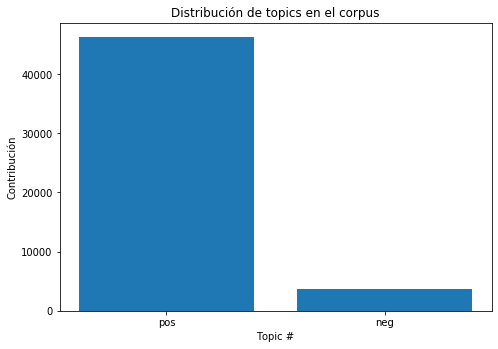

In [25]:
ser =df['sentiment_label'].value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ser.index, ser.array)
plt.xlabel('Topic #')
plt.ylabel('Contribución')
plt.title("Distribución de topics en el corpus")
plt.show()

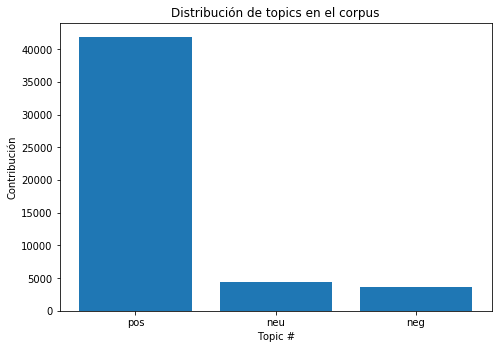

In [26]:
ser =df['sentiment'].value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ser.index, ser.array)
plt.xlabel('Topic #')
plt.ylabel('Contribución')
plt.title("Distribución de topics en el corpus")
plt.show()

## 3.2 Separación train/test

Como sospechábamos, tal y como demuestra los gráficos de distribución de topics, los datos están totalmente desbalanceados, por lo que tendremos que estratificar en el proceso de separación train/test. Inicialmente vamos a realizar un el estudio sobre el caso simple de sentimiento positivo/negativo

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    df['reviewText'],
    df['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=2,
    shuffle=True,
    stratify=df['sentiment_label']
)

In [28]:
# Examinamos algunas entardas de X_train
X_train.iloc[100:120]

25196    I have had a love-hate relationship with HP an...
26547    Avery's Page Markers are useful for marking a ...
22544    We've used these all over the house for a vari...
30967    I purchased this computer as a replacement for...
49851    This coffee pot worked for a feww days then st...
25417    This is a great 3-hole punch.  It does what it...
42189    If I could give this little oven 6 stars...I w...
2757     They are plenty bright and use essentially no ...
6935     There are no Mother's products that I have tri...
3400     It comes with 2 100gram bar. Based on some rev...
43192    For all those that complain about the size of ...
37789    Keep this in the go box in my car. Fits my han...
12691    I have Orthaheel flip flops and LOVE them... s...
23484    I use various Post It products. I actually fin...
48165           It REALLY is nonstick.  Excellent results.
30275    Car camping trip day 2:  eggs in cooler, moved...
15553    I loved the design of this wallet, with the cl.

In [29]:
# Examinamos algunas entradas de y_train (hemos hecho varias comprobaciones para encontrar valore neg)
y_train.iloc[100:120]

25196    pos
26547    pos
22544    pos
30967    pos
49851    neg
25417    pos
42189    pos
2757     pos
6935     pos
3400     pos
43192    pos
37789    pos
12691    pos
23484    pos
48165    pos
30275    pos
15553    neg
3024     pos
43347    pos
47600    pos
Name: sentiment_label, dtype: object

## 3.3 Extracción de features

La extracción de características las vamos a realizar con Tfidfvectorizer, seleccionando palabras, bigramas y trigramas. Se ha decidido eliminar stopwords, porque en una primera ejecución en la que no se eliminaron se vio que aparecían determinantes, conjunciones, etc., aunque es cierto que aparecían como las palabras de menos importancia. Este tipo de palabras para el análisis de sentimiento creemos que, aunque parece que no afectan mucho por lo que se dedujo en una primera inspección, lo único que hacen es añadir ruido.

El resultado que se obtuvo sin la eliminación de stopwords fue:

Top 10 words with lowest TF_IDF in the review 15958:  
          tfidf 
and    0.049035  
or     0.048869  
great  0.048044  
they   0.045062  
are    0.041778  
with   0.037626  
of     0.032807  
for    0.031243  
is     0.031199  
to     0.026703  

Por otro lado, aunque con la lematiazción reduciríamos el número de palabras y por tanto el rendimiento sería mejor, decidimos no lematizar, ya que, a priori, se intuye que el sentimiento se detecta mejor utilizando sin convertir las palabras a su base. Es importante, por ejemplo, frases en pasado, futuro, etc. También es cierto que en este caso queremos probar a no lematizar, porque en el ejercicio de Topic Modeling hemos lematizado. Asimismo, tampoco quitamos números, aunque se podrían haber eliminado.

In [30]:
%%time
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=25000,
    stop_words=text.ENGLISH_STOP_WORDS,
    strip_accents='ascii',
    ngram_range=(1, 3) # buscamos palabras, bigramas y trigramas
)
cv.fit(X_train)

CPU times: user 16 s, sys: 188 ms, total: 16.2 s
Wall time: 16.2 s


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95,
                max_features=25000, min_df=5, ngram_range=(1, 3), norm='l2',
                preprocessor=None, smooth_idf=True,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}),
                strip_accents='ascii', sublinear_tf=False,
                tok

In [31]:
# Analizamos los primeros valores, donde se observa algún bigrama
print(list(cv.vocabulary_.items())[:20])

[('shirt', 19346), ('present', 16167), ('sister', 19591), ('loved', 12840), ('fits', 7696), ('perfectly', 15487), ('looks', 12605), ('pretty', 16202), ('thank', 21516), ('fits perfectly', 7717), ('perfectly looks', 15505), ('looks pretty', 12645), ('item', 10606), ('excellent', 6875), ('good', 8458), ('expected', 6946), ('reason', 17671), ('recommend', 17752), ('product', 16723), ('feel', 7332)]


In [32]:
# Tamaño del vocabulario
print(len(cv.vocabulary_))

25000


### 3.3.1 TF-IDF scores del training set y test set

In [33]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

### 3.3.2 Score IDF de algunas palabras

In [34]:
words_example = [
    'printer',
    'socket',
    'fits',
    'fits perfectly',
    'perfectly',
    'jeans'
]

In [35]:
vocab_idf = dict(zip(cv.get_feature_names(), cv.idf_))

print('{0:20}{1:20}'.format('Palabra', 'IDF'))
for word in words_example:
    if word not in vocab_idf:
        print('{0:20}{1:20}'.format(word, 'OOV'))
    else:
        print('{0:20}{1:2.3f}'.format(word, vocab_idf[word]))

Palabra             IDF                 
printer             4.439
socket              6.841
fits                3.924
fits perfectly      5.968
perfectly           4.110
jeans               5.880


Se ve cómo el bigrama _fits perfectly_ influye más que la palabra _fits_ y que _perfectly_.

### 3.3.4 Palabras con el TF-IDF en alguna review elegida al azar

In [36]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 18893
Sentiment: pos
Review: Nice balance, very sharp, stiff blade makes cutting straight a breeze.  The 10&#34; blade is perfect for not only cakes but round farmers loaves and sourdough breads.  Perfect.


In [37]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 18893:
                tfidf
blade        0.326556
34 blade     0.302976
sourdough    0.302976
blade makes  0.283681
10 34        0.269177
loaves       0.268025
breads       0.260927
cakes        0.248856
perfect      0.226812
balance      0.208094

Top 10 words with lowest TF_IDF in the review 18893:
             tfidf
stiff     0.196023
breeze    0.194422
round     0.186359
straight  0.179508
cutting   0.177870
sharp     0.159334
10        0.136996
34        0.132272
makes     0.119466
nice      0.097500


### 3.3.5 $\chi²$ scores

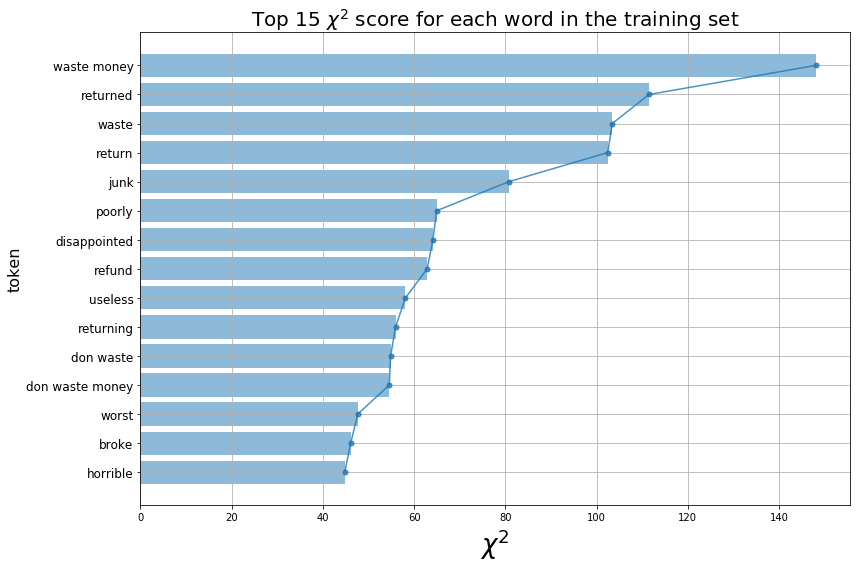

In [38]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('token', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

Por el gráfico anterior se observa cómo las palabras con mayor puntuación son las que denotan sentimiento negativo y destaca la palabra _waste_ tanto de forma independiente, como formando parte de bigramas e incluso trigramas.

## 3.3.6 Entrenamiento

Al ser nuestro target binario, vamos a entrenar un modelo de regresión logística.

In [39]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.9272
Accuracy for C=0.05: 0.9272
Accuracy for C=0.25: 0.92792
Accuracy for C=0.5: 0.93064
Accuracy for C=1: 0.93376
Accuracy for C=10: 0.93864
Accuracy for C=100: 0.93352
Accuracy for C=1000: 0.92784
Accuracy for C=10000: 0.9212


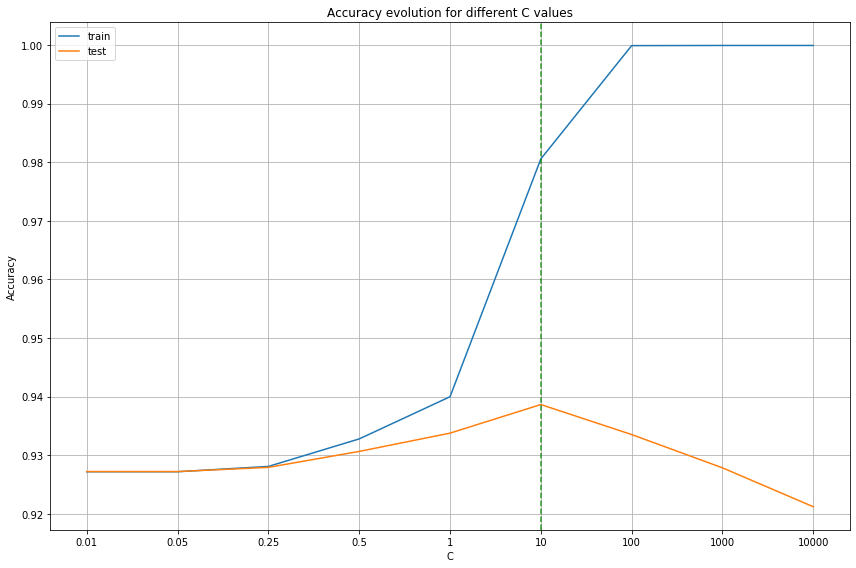

In [40]:
# Representamos los distintso accuracy obtenidos
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

Se observa que el mejor accuracy lo tendríamos más o menos para C=1, porque para valores superior el modelo aprende demasiado y no generaliza. Es cierto que el accuracy máximo está en C=10, pero vemos que train tiene overfitting. No obstante, vamos a analizar las métricas de ambos valores

In [41]:
lr = LogisticRegression(C=1, solver='lbfgs', max_iter=500)
lr.fit(X_train_, y_train)
   
train_predict = lr.predict(X_train_)
test_predict = lr.predict(X_test_)


print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[  108   802]
 [   26 11564]]

Classification report:
              precision    recall  f1-score   support

         neg       0.81      0.12      0.21       910
         pos       0.94      1.00      0.97     11590

    accuracy                           0.93     12500
   macro avg       0.87      0.56      0.59     12500
weighted avg       0.93      0.93      0.91     12500

Accuracy score:0.93376


In [42]:
lr = LogisticRegression(C=10, solver='lbfgs', max_iter=500)
lr.fit(X_train_, y_train)
   
train_predict = lr.predict(X_train_)
test_predict = lr.predict(X_test_)


print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[  274   636]
 [  131 11459]]

Classification report:
              precision    recall  f1-score   support

         neg       0.68      0.30      0.42       910
         pos       0.95      0.99      0.97     11590

    accuracy                           0.94     12500
   macro avg       0.81      0.64      0.69     12500
weighted avg       0.93      0.94      0.93     12500

Accuracy score:0.93864


Las métricas de ambos casos son muy parecidas y vemos que la precisión y recall para los casos positivos son bastantes buenos. La precisión para los casos negativos también podemos considerarla buena (con c=1), aunque el recall no es muy bueno: hay mucho falso positivo.

Vamos a seguir analizando los datos utilizando otros modelos, y una vez elegido el que mejor datos arroje a priori analizaremos sus métricas cambiando parámetros del vectorizer. Para hacer el ejercicio más realista, vamos a considerar también el sentimiento neutro.

## 3.4 Extracción de features con pipelines

En esta sección vamos a repetir parcialmente lo hecho en la sección 3.4 Extracción de features, pero utilizando pipelines y evaluando distintos modelos de clasificación.


In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    df['reviewText'],
    df['sentiment'],
    train_size=0.75,
    test_size=0.25,
    random_state=2,
    shuffle=True,
    stratify=df['sentiment']
)

### 3.4.1 Multinominal Naive Bayes

El clasificador Niave Bayes multinominal es más adecuado para el recuento de palabras donde los datos se representan típicamente como recuentos de vectores de palabras (número de veces que se observa el número de resultado X [i, j] durante los n ensayos), ignorando a su vez la no ocurrencia de una característica i.

Naive Bayes es una versión simplificada del Teorema de Bayes, donde se supone que todas las características están condicionadas independientemente entre sí (los clasificadores), P (x | y) donde x es la característica e y es el clasificador.


#### 3.4.1.1 Entrenamiento

In [44]:
%%time
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
multiNB = Pipeline([("vect", CountVectorizer(max_df=0.95,
                                min_df=5,
                                max_features=25000,
                                stop_words=text.ENGLISH_STOP_WORDS,
                                strip_accents='ascii',
                                ngram_range=(1, 3))), 
                    ("tfidf", TfidfTransformer()), 
                    ("mutilnominalNB", MultinomialNB())])
multiNB.fit(X_train, y_train)

CPU times: user 15.7 s, sys: 157 ms, total: 15.9 s
Wall time: 15.9 s


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.95,
                                 max_features=25000, min_df=5,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',...
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow', 'anyone',
       

#### 3.4.1.2 Testeo

In [45]:
import numpy as np
predictedMultiNB = multiNB.predict(X_test)
np.mean(predictedMultiNB == y_test)

0.83984

### 3.4.2 Support Vector Machine Classifier

In [46]:
%%time
from sklearn.svm import LinearSVC
linearSVC = Pipeline([("vect", CountVectorizer(max_df=0.95,
                                min_df=5,
                                max_features=25000,
                                stop_words=text.ENGLISH_STOP_WORDS,
                                strip_accents='ascii',
                                ngram_range=(1, 3))), 
                    ("tfidf", TfidfTransformer()), 
                    ("linearSVC", LinearSVC())])
linearSVC.fit(X_train, y_train)

predictedLinearSVC = linearSVC.predict(X_test)
np.mean(predictedLinearSVC == y_test)

CPU times: user 17.9 s, sys: 175 ms, total: 18 s
Wall time: 18 s


0.85856

### 3.4.3 Decision Tree

In [47]:
%%time
from sklearn.tree import DecisionTreeClassifier
decisionTree = Pipeline([("vect", CountVectorizer(max_df=0.95,
                                min_df=5,
                                max_features=25000,
                                stop_words=text.ENGLISH_STOP_WORDS,
                                strip_accents='ascii',
                                ngram_range=(1, 3))), 
                    ("tfidf", TfidfTransformer()), 
                    ("decissionTree", DecisionTreeClassifier())])
decisionTree.fit(X_train, y_train)

predictedDecisionTree = decisionTree.predict(X_test)
np.mean(predictedDecisionTree == y_test)

CPU times: user 1min 5s, sys: 133 ms, total: 1min 6s
Wall time: 1min 6s


0.78296

### 3.4.4 Radom Forest

In [48]:
%%time
from sklearn.ensemble import RandomForestClassifier
radomForest = Pipeline([("vect", CountVectorizer(max_df=0.95,
                                min_df=5,
                                max_features=25000,
                                stop_words=text.ENGLISH_STOP_WORDS,
                                strip_accents='ascii',
                                ngram_range=(1, 3))), 
                    ("tfidf", TfidfTransformer()), 
                    ("decissionTree", RandomForestClassifier())])
radomForest.fit(X_train, y_train)

predictedRadomForest = radomForest.predict(X_test)
np.mean(predictedRadomForest == y_test)

CPU times: user 1min 18s, sys: 187 ms, total: 1min 18s
Wall time: 1min 18s


0.84568

### 3.4.5 Ajuste de SVM

Como se puede comprobar, de todas los modelos de clasifición utilizados, el que obtiene un resultado algo mejor es SVM. Tal y como hicimos en el módulo de ML, vamos a realizar un ajuste sobre el modelo SVM ejecutado un cross-validation con distintos parámetros. En este caso, solo vamos a probar cambiar el número de n-gramas y utilizar o no el idf.

In [49]:
%%time
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],    
             'tfidf__use_idf': (True, False), 
             } 
gscv_linearSVC = GridSearchCV(linearSVC, parameters, n_jobs=-1)
final_linearSVC_model = gscv_linearSVC.fit(X_train, y_train)

CPU times: user 17.8 s, sys: 1.4 s, total: 19.2 s
Wall time: 1min 43s


In [50]:
predicted_gscv_linearSVC = final_linearSVC_model.predict(X_test)
np.mean(predicted_gscv_linearSVC == y_test)

0.862

Hemos conseguido mejorar el modelo hasta obtener un 86.2% de _acierto_ con respecto al dataset de test.

In [51]:
# Mostramos el mejor score, que al no haber indicado nada en el GridSearchCV, por defecto, es accuracy
print(gscv_linearSVC.best_score_)

0.8601599999999999


El valor obtenido de accuracy es prácticamente igual a la media de aciertos predichos en el dataset de test

In [52]:
# datos del mejor estimador
print(gscv_linearSVC.best_estimator_)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.95,
                                 max_features=25000, min_df=5,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',...
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
         

In [53]:
# mejores parámetros
print(gscv_linearSVC.best_params_)

{'tfidf__use_idf': False, 'vect__ngram_range': (1, 3)}


Los mejores parámetros corresponden a no utilizar el idf en el tfidf y a utilizar trigramas.

A continuación, presentamos algunas métricas, del mismo modo que lo hemos hecho en la regresión logarítima en donde  únicamente considerábamos sentimiento positivo y negativo, al contrario que ahora, donde también tenemos en cuenta el sentimiento neutro.

In [54]:
from sklearn.metrics import accuracy_score
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, predicted_gscv_linearSVC)))
print(classification_report(y_test, predicted_gscv_linearSVC))
print('Accuracy: {}'.format(accuracy_score(y_test, predicted_gscv_linearSVC)))

Confussion matrix:
[[  362    80   468]
 [  110   145   843]
 [  114   110 10268]]
              precision    recall  f1-score   support

         neg       0.62      0.40      0.48       910
         neu       0.43      0.13      0.20      1098
         pos       0.89      0.98      0.93     10492

    accuracy                           0.86     12500
   macro avg       0.65      0.50      0.54     12500
weighted avg       0.83      0.86      0.83     12500

Accuracy: 0.862


Obtenemos una valores bastantes buenos para la precisión de los positivos. El recall también es muy bueno. La precisión de los negativos no podemos considerarla como muy buena, y el recall no lo es. Los datos para los valores neutros no son muy buenos. Estos datos son algo inferiores a los obtenido en el análisis de solo positivos y negativos.

Aunque la predicción de los valores negativos y neutros, sobre todo de estos últimos, no se puede considerar buena, el obtener un 86.2% de accuracy indica que el modelo de predicción es aceptable. Se intuye que realizando el mismo proceso con muchos más datos y con más capacidad de computación, los modelos obtenidos mejorarían.

## 3.5 Análisis de sentimiento con VADER
En esta sección vamos a realizar una pequeña práctica con VADER, comparando el resultado de sentimiento que calcula esta técnica, con el sentimiento que previamente tenemos etiquetado en función de las estrellas de las estrellas de las reviews.

In [55]:
#!pip install vaderSentiment

In [56]:
# función para calcular el sentimiento que produce una determinada frase según VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def vader_sentimental_score(sentence):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(sentence)
    score=vs['compound']
    if score >= 0.5:
        return 'pos'
    elif (score > -0.5) and (score < 0.5):
        return 'neu'
    elif score <= -0.5:
        return 'neg'

Añadimos una nueva columna con el cálculo VADER (12 minutos)

In [57]:
%%time
df['vader_sentiment'] = df.apply(lambda row: vader_sentimental_score(row['reviewText']), axis=1)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [58]:
df.head()

reviewText  overall sentiment_label  \
0  This unit eliminates the need for a gauge and ...        5             pos   
1  This product is very easy to use make sure tha...        5             pos   
2  An excellent all around scanner, capable of re...        5             pos   
3  I had a Power Madd clip, and it broke. So I de...        3             pos   
4  Best cleaner I have used so far.  I recently c...        5             pos   

  sentiment vader_sentiment  
0       pos             neu  
1       pos             pos  
2       pos             pos  
3       neu             neg  
4       pos             pos

In [59]:
np.mean(df['sentiment'] == df['vader_sentiment'])

0.73502

Se observa que VADER predice el sentimiento de las frases en un 73.5% de forma correcta a lo que nosotros hemos considerado como positivo, neutro y negativo según las estrellas de las reviews.

### 3.5.1 Nube de palabras

En este epígrafe vamos a dibujar dos nubes de palabras, una para las palabras que generan sentimiento positivo y otras para que generan sentimiento negativo, según VADER

In [60]:
# Obtenemos los subdataframe de sentimiento positivo y negativo
pos_df = df.loc[df['vader_sentiment'] == 'pos']
neg_df = df.loc[df['vader_sentiment'] == 'neg']

In [61]:
pos_df.head()

reviewText  overall sentiment_label  \
1  This product is very easy to use make sure tha...        5             pos   
2  An excellent all around scanner, capable of re...        5             pos   
4  Best cleaner I have used so far.  I recently c...        5             pos   
6                                   Worked perfectly        5             pos   
8  i needed something to level out my camper othe...        5             pos   

  sentiment vader_sentiment  
1       pos             pos  
2       pos             pos  
4       pos             pos  
6       pos             pos  
8       pos             pos

In [62]:
pos_df.shape

(38476, 5)

In [63]:
neg_df.head()

reviewText  overall  \
3   I had a Power Madd clip, and it broke. So I de...        3   
10  The first one of these I bought was three year...        5   
23  I bought this because what i thought was the s...        5   
29  At fist I thought this pad was first rate but ...        1   
63  My 6 years old Mazda 6 2.5 liters GH 5 speed s...        2   

   sentiment_label sentiment vader_sentiment  
3              pos       neu             neg  
10             pos       pos             neg  
23             pos       pos             neg  
29             neg       neg             neg  
63             neg       neg             neg

In [64]:
neg_df.shape

(2062, 5)

In [65]:
# Para reducir el número de palabras, 
# vamos a realizar un preprocesado con distintos pasos, similar al utilizado en Topic Modeling
wordnet_lemmatizer = WordNetLemmatizer()
def text_preprocessing(text, min_length_word=3):
    tokens=gensim.utils.simple_preprocess((text.lower())) # realizamos un preprocesado simple gensim, donde, 
                                                          # por ejemplo, se quitan números
    tokens = [t for t in tokens if len(t) > min_length_word] # eliminamos la palabras pequeñas porque se suponen que no aportan

    tokens=[wordnet_lemmatizer.lemmatize(t) for t in tokens] # lematitazamos las palabras a su base
    tokens = [t for t in tokens if t not in gensim.parsing.preprocessing.STOPWORDS] # eliminar stopwords de gensim

    return tokens

In [66]:
def create_word_corpus(data):
    word_corpus = ''
    for review in data['reviewText']:
        tokens = text_preprocessing(review)
        for word in tokens:
            word_corpus = word_corpus + word + ' '
    return word_corpus

Generamos la nube de palabras positivas y negativas

In [67]:
%%time
positive_wordcloud = WordCloud(width=900, height=500, max_font_size=50, max_words=100
                               , background_color="white").generate(create_word_corpus(pos_df))


CPU times: user 14min 46s, sys: 2min 3s, total: 16min 49s
Wall time: 21min 26s


In [68]:
%%time
negative_wordcloud = WordCloud(width=900, height=500, max_font_size=50, max_words=100
                               , background_color="white").generate(create_word_corpus(neg_df))

CPU times: user 2.87 s, sys: 23 ms, total: 2.89 s
Wall time: 2.89 s


In [70]:
def plot_word_cloud(wordcloud):
    plt.figure( figsize=(12,6), facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

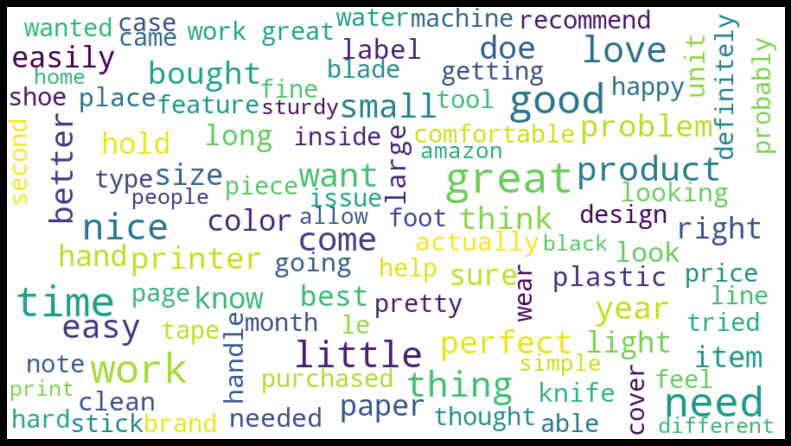

In [71]:
plot_word_cloud(positive_wordcloud)

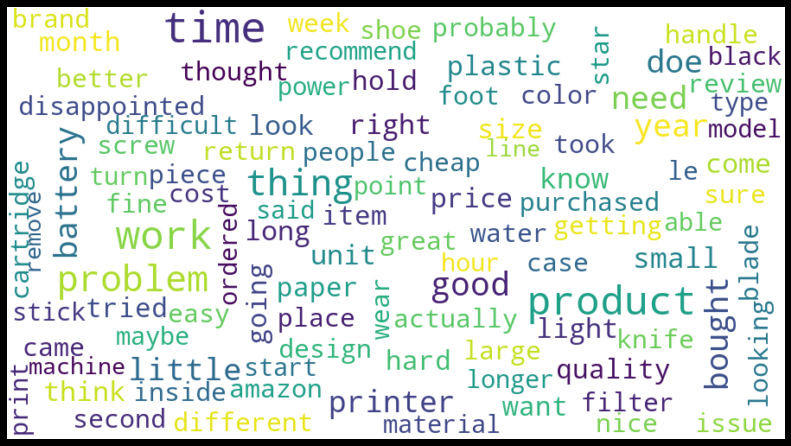

In [72]:
plot_word_cloud(negative_wordcloud)

Observamos que hay palabras comunes en ambas nubes de palabras que, a priori, son neutras en cuanto al sentimiento positivo y negativo, y que hay alguna de sentimiento positivo que está en la nube de negativas, como good y nice. De todas formas, sí que se ve hay palabaras negativas que solo están en la nube de negativas como disappointed, problem o hard. También hay palabras positivas que solo están en la nube de positivas como better, perfect, easy.